In [1]:
# generative model
from src.SlovotvirModelM import run_model_parallel

# bayesflow components
import bayesflow.diagnostics as diag

# helpher functions
from src.helpers import (generate_latex_table,
                         binning,
                         plot_posterior,
                         train_and_amortize, 
                         letter_subplots)

# other
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

/opt/homebrew/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
RNG = np.random.default_rng(2023)

## Inference of all 3 parameters

In [5]:
train_size = 1000
test_size = 10
valid_size = 10

### 1. Generating training and testing data

In [6]:
# training_params = (np.random.uniform(0, 10, train_size), np.random.uniform(0, 10, train_size), np.random.lognormal(0, 0.5, train_size))
# testing_params = (np.random.uniform(0, 10, test_size), np.random.uniform(0, 10, test_size), np.random.lognormal(0, 0.5, test_size))
# validation_params = (np.random.uniform(0, 10, valid_size), np.random.uniform(0, 10, valid_size), np.random.lognormal(0, 0.5, valid_size))

In [7]:
# training_data = run_model_parallel(training_params[0], training_params[1], training_params[2], train_size)

In [8]:
# testing_data = run_model_parallel(testing_params[0], testing_params[1], testing_params[2], test_size)

In [9]:
# validation_data = run_model_parallel(validation_params[0], validation_params[1], validation_params[2], valid_size)

In [10]:
# training_params = np.vstack(training_params)
# testing_params = np.vstack(testing_params)
# validation_params = np.vstack(validation_params)

In [11]:
# train_data = {}
# train_data["prior_non_batchable_context"] = None
# train_data["prior_batchable_context"] = None
# train_data["prior_draws"] = training_params.reshape(num_params, train_size).T
# train_data["sim_non_batchable_context"] = None
# train_data["sim_batchable_context"] = None
# train_data["sim_data"] = np.array(training_data, dtype = float)


# test_data = {}
# test_data["prior_non_batchable_context"] = None
# test_data["prior_batchable_context"] = None
# test_data["prior_draws"] = testing_params.reshape(num_params, test_size).T
# test_data["sim_non_batchable_context"] = None
# test_data["sim_batchable_context"] = None
# test_data["sim_data"] = np.array(testing_data, dtype = float)

# valid_data = {}
# valid_data["prior_non_batchable_context"] = None
# valid_data["prior_batchable_context"] = None
# valid_data["prior_draws"] = validation_params.reshape(num_params, valid_size).T
# valid_data["sim_non_batchable_context"] = None
# valid_data["sim_batchable_context"] = None
# valid_data["sim_data"] = np.array(validation_data, dtype = float)

In [12]:
# pickle.dump(train_data, open("data/train_data_1405.pkl", "wb"))
# pickle.dump(test_data, open("data/test_data_1405.pkl", "wb"))
# pickle.dump(valid_data, open("data/valid_data_1405.pkl", "wb"))
# load data
train_data = pickle.load(open("data/train_data_1405.pkl", "rb"))
test_data = pickle.load(open("data/test_data_1405.pkl", "rb"))
valid_data = pickle.load(open("data/valid_data_1405.pkl", "rb"))

In [13]:
# train_data_ = pickle.load(open("data/train_data_1205.pkl", "rb"))
# test_data_ = pickle.load(open("data/test_data_1205.pkl", "rb"))
# valid_data_ = pickle.load(open("data/valid_data_1205.pkl", "rb"))

In [14]:
# # train_data["sim_data"].shape
# train_data_["sim_data"] = np.array(list(map(binning, train_data_["sim_data"])))
# test_data_["sim_data"] = np.array(list(map(binning, test_data_["sim_data"])))
# valid_data_["sim_data"] = np.array(list(map(binning, valid_data_["sim_data"])))

In [15]:
# # combine sim_data and prior_draws
# train_data["sim_data"] = np.concatenate((train_data["sim_data"], train_data_["sim_data"]))
# train_data["prior_draws"] = np.concatenate((train_data["prior_draws"], train_data_["prior_draws"]))
# test_data["sim_data"] = np.concatenate((test_data["sim_data"], test_data_["sim_data"]))
# test_data["prior_draws"] = np.concatenate((test_data["prior_draws"], test_data_["prior_draws"]))
# valid_data["sim_data"] = np.concatenate((valid_data["sim_data"], valid_data_["sim_data"]))
# valid_data["prior_draws"] = np.concatenate((valid_data["prior_draws"], valid_data_["prior_draws"]))

In [16]:
# # apply binning to each entry in sim_data using map
# train_data["sim_data"] = np.array(list(map(binning, train_data["sim_data"])))
# test_data["sim_data"] = np.array(list(map(binning, test_data["sim_data"])))
# valid_data["sim_data"] = np.array(list(map(binning, valid_data["sim_data"])))

In [17]:
prior_means = np.mean(train_data["prior_draws"], axis=0)
prior_stds = np.std(train_data["prior_draws"], axis=0)

In [18]:
train_data['sim_data'].shape

(80000, 17)

### 2. Training the model

In [56]:
num_params = 3
epochs = 100
batch_size = 32
learning_rate = 0.001

In [57]:
history, trainer, amortizer = train_and_amortize(train_data, batch_size, test_data, epochs, 
                                                 num_params, 4, learning_rate, prior_means, prior_stds)

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!


Training epoch 1:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Loss: 1.471


Training epoch 2:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 1.035


Training epoch 3:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 0.970


Training epoch 4:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Loss: 0.812


Training epoch 5:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Loss: 0.755


Training epoch 6:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Loss: 0.384


Training epoch 7:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Loss: 0.576


Training epoch 8:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Loss: 0.216


Training epoch 9:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Loss: 0.107


Training epoch 10:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Loss: -0.288


Training epoch 11:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 11, Loss: -0.499


Training epoch 12:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 12, Loss: -0.745


Training epoch 13:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 13, Loss: -0.695


Training epoch 14:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 14, Loss: -0.776


Training epoch 15:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 15, Loss: -0.166


Training epoch 16:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 16, Loss: -0.853


Training epoch 17:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 17, Loss: -1.011


Training epoch 18:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 18, Loss: -0.625


Training epoch 19:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 19, Loss: -0.966


Training epoch 20:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 20, Loss: -0.952


Training epoch 21:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 21, Loss: -0.857


Training epoch 22:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 22, Loss: -1.050


Training epoch 23:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 23, Loss: -1.122


Training epoch 24:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 24, Loss: -1.302


Training epoch 25:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 25, Loss: -1.168


Training epoch 26:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 26, Loss: -0.877


Training epoch 27:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 27, Loss: -1.305


Training epoch 28:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 28, Loss: -1.361


Training epoch 29:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 29, Loss: -1.139


Training epoch 30:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 30, Loss: -1.116


Training epoch 31:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 31, Loss: -1.377


Training epoch 32:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 32, Loss: -1.321


Training epoch 33:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 33, Loss: -1.108


Training epoch 34:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 34, Loss: -1.445


Training epoch 35:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 35, Loss: -1.268


Training epoch 36:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 36, Loss: -1.078


Training epoch 37:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 37, Loss: -1.569


Training epoch 38:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 38, Loss: -1.542


Training epoch 39:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 39, Loss: -1.551


Training epoch 40:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 40, Loss: -1.461


Training epoch 41:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 41, Loss: -1.371


Training epoch 42:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 42, Loss: -1.512


Training epoch 43:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 43, Loss: -1.596


Training epoch 44:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 44, Loss: -1.592


Training epoch 45:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 45, Loss: -1.429


Training epoch 46:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 46, Loss: -1.437


Training epoch 47:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 47, Loss: -1.655


Training epoch 48:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 48, Loss: -1.650


Training epoch 49:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 49, Loss: -1.609


Training epoch 50:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 50, Loss: -1.752


Training epoch 51:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 51, Loss: -1.639


Training epoch 52:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 52, Loss: -1.759


Training epoch 53:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 53, Loss: -1.742


Training epoch 54:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 54, Loss: -1.678


Training epoch 55:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 55, Loss: -1.631


Training epoch 56:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 56, Loss: -1.829


Training epoch 57:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 57, Loss: -1.833


Training epoch 58:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 58, Loss: -1.754


Training epoch 59:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 59, Loss: -1.799


Training epoch 60:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 60, Loss: -1.611


Training epoch 61:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 61, Loss: -1.860


Training epoch 62:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 62, Loss: -1.848


Training epoch 63:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 63, Loss: -1.847


Training epoch 64:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 64, Loss: -1.923


Training epoch 65:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 65, Loss: -1.924


Training epoch 66:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 66, Loss: -1.899


Training epoch 67:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 67, Loss: -1.941


Training epoch 68:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 68, Loss: -1.947


Training epoch 69:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 69, Loss: -1.955


Training epoch 70:   0%|          | 0/2500 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 70, Loss: -1.945
INFO:root:Early stopping triggered.


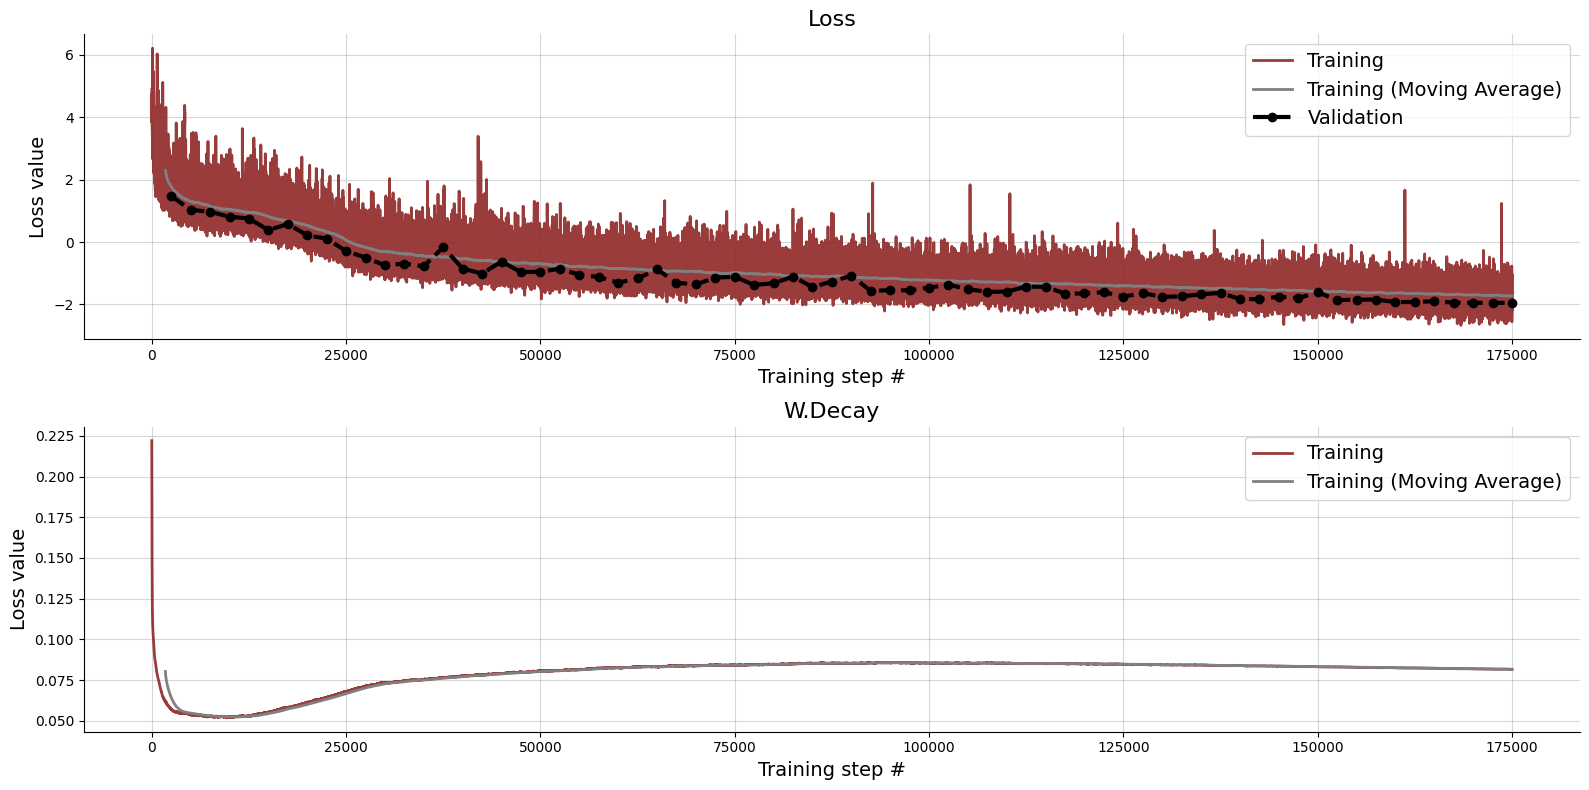

In [58]:
f = diag.plot_losses(history["train_losses"], history["val_losses"], moving_average=True)

### 3. Model analysis

In [103]:
# Generate some validation data
validation_sims = trainer.configurator(valid_data) 
prior_samples = validation_sims["parameters"] * prior_stds + prior_means
# Generate posterior draws for all simulations
post_samples = amortizer.sample(validation_sims, n_samples=100)
post_samples = post_samples * prior_stds + prior_means

In [19]:
fig = diag.plot_recovery(post_samples[0:1000], prior_samples[0:1000], add_corr=False,
                         param_names=['Length bias (α)', 'Frequency bias (β)', 'Skew strength (τ)'],
                         )
# point_agg=np.mean, uncertainty_agg=np.std

NameError: name 'post_samples' is not defined

In [91]:
post_samples.shape

(8000, 100, 3)

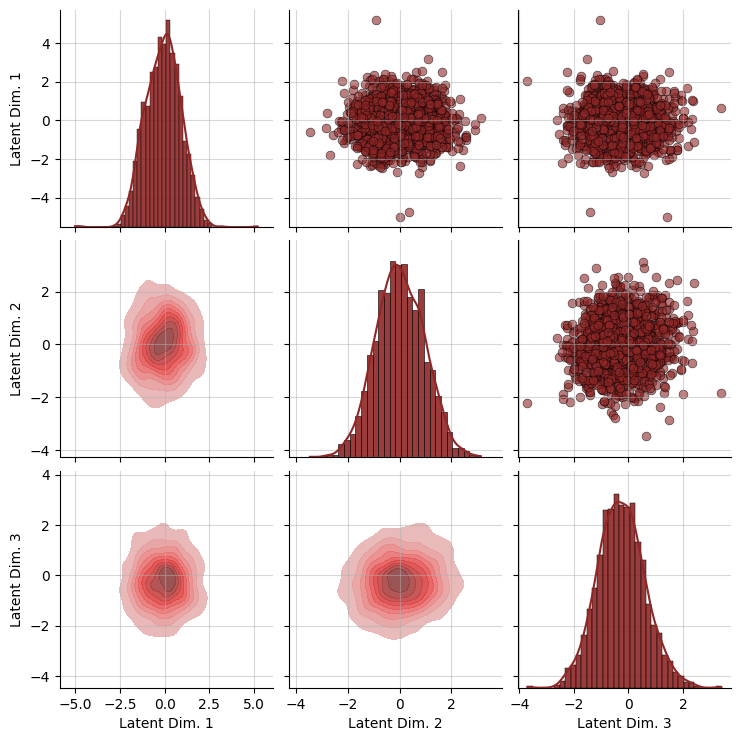

In [92]:
f = trainer.diagnose_latent2d()

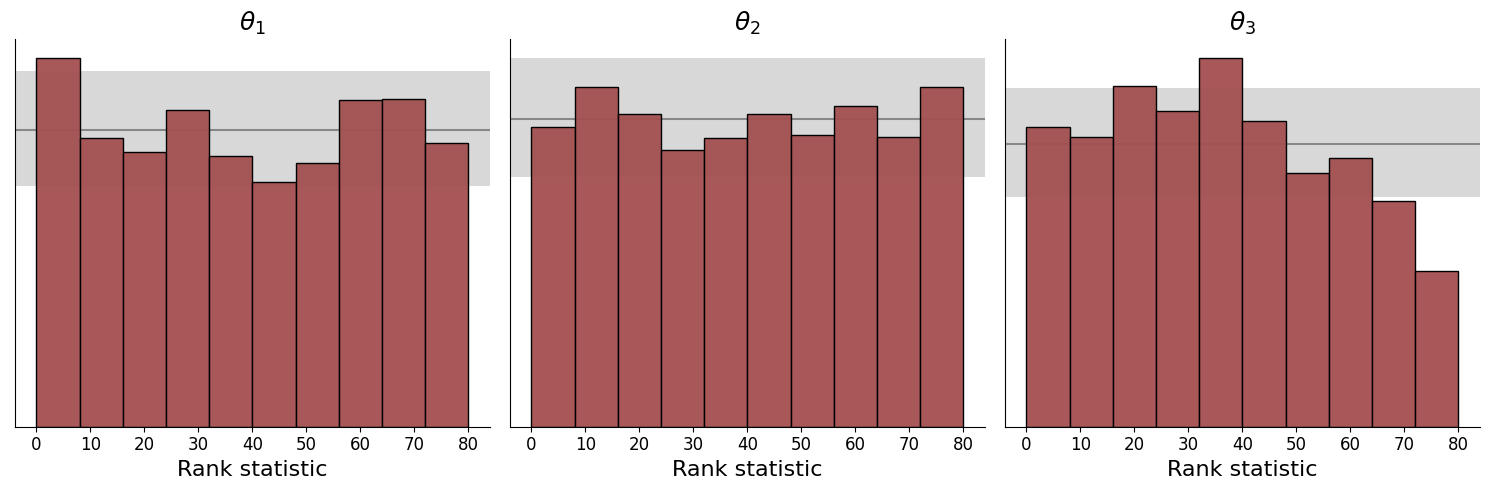

In [93]:
f = trainer.diagnose_sbc_histograms()

### 4. Posterior analysis

In [124]:
a = 1
b = 2
tau = 1

In [125]:
fake_dist = run_model_parallel([a], [b], [tau], 1)
# apply binning to each entry in sim_data using map
fake_dist = np.array(list(map(binning, fake_dist)))

In [126]:
obs_data = np.log1p(fake_dist[0])[np.newaxis, :, np.newaxis].astype(np.float32)

In [127]:
# Obtain 500 posterior draws given real data
post_samples_ = amortizer.sample({"summary_conditions": obs_data}, 10000)

# Undo standardization to get parameters on their original (unstandardized) scales
post_samples_ = prior_means + post_samples_ * prior_stds

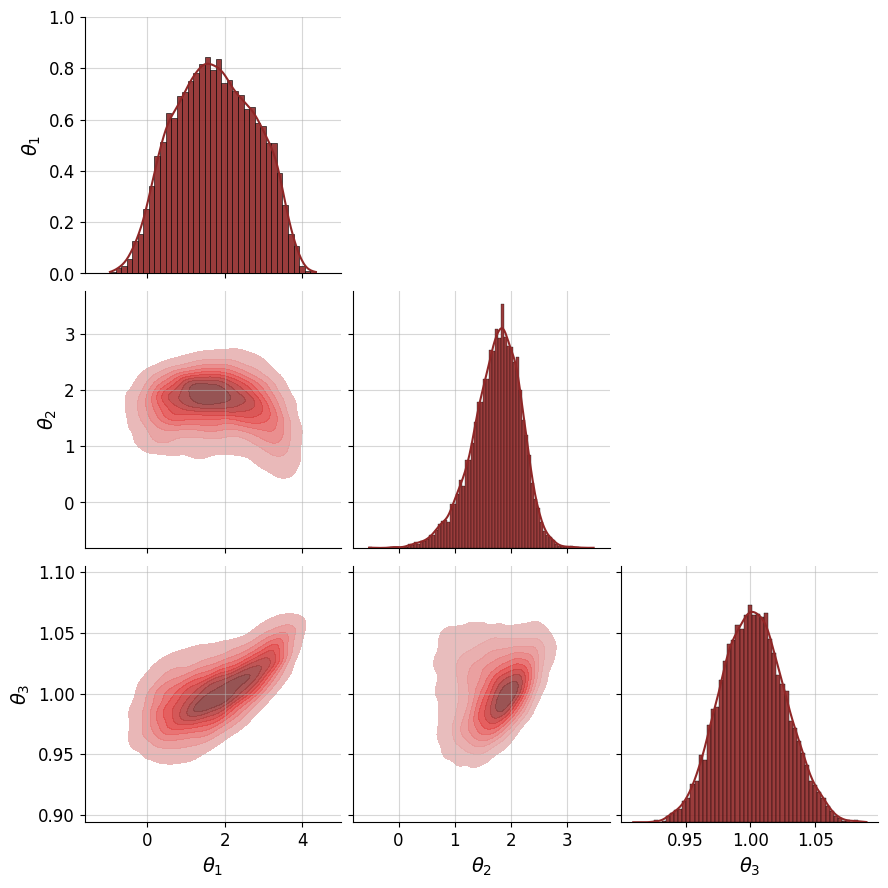

In [128]:
f = diag.plot_posterior_2d(post_samples_)

In [129]:
print(generate_latex_table(['Length bias (α)', 'Frequency bias (β)', 'Skew strength (τ)'], post_samples_))

\begin{tabular}{lrl}
\hline
 Parameter          &   Mean & HDI             \\
\hline
 Length bias (α)    &  1.747 & [-0.059  3.574] \\
 Frequency bias (β) &  1.737 & [0.82  2.545]   \\
 Skew strength (τ)  &  1.002 & [0.953 1.049]   \\
\hline
\end{tabular}


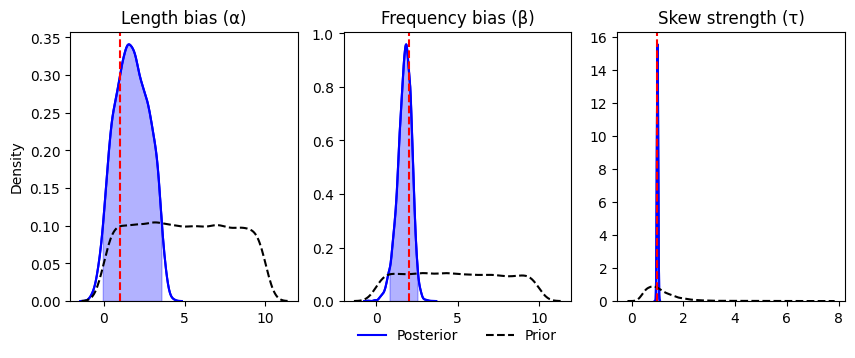

In [130]:
plot_posterior(post_samples_, ['Length bias (α)', 'Frequency bias (β)', 'Skew strength (τ)'], [a, b, tau], save=None)

In [131]:
# Perform PCA
pca = PCA(n_components=2, whiten=True)
pca_result = pca.fit_transform(train_data['sim_data'])

true_hist = obs_data.reshape(1, -1)
pca_true = pca.transform(true_hist)

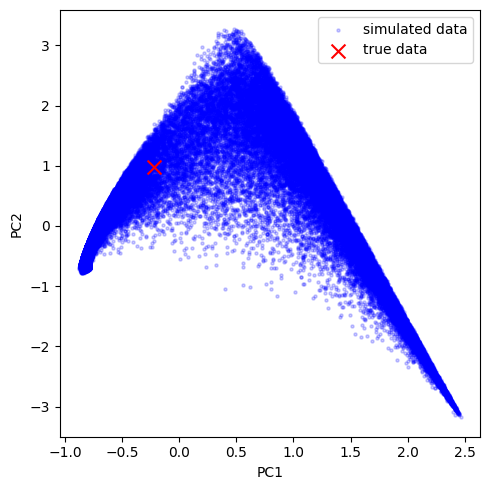

In [132]:
# Plot PCA
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(pca_result[:, 0], pca_result[:, 1], 
            s=5, color = 'blue', 
            alpha=0.2, label='simulated data')
plt.scatter(pca_true[:, 0], pca_true[:, 1],
             s=100, color='red', marker='x', 
             label='true data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.tight_layout()
plt.savefig('figures/pca.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## Inference of alpha and beta knowing tau

### 1. Data generation

In [36]:
train_size = 1000
test_size = 10
valid_size = 10

num_params = 2

In [37]:
np.mean(post_samples_[:, 2])

0.9832328004705781

In [38]:
training_params_2 = (np.random.uniform(0, 10, train_size), 
                   np.random.uniform(0, 10, train_size), 
                  [np.mean(post_samples_[:, 2])] * train_size)
testing_params_2 = (np.random.uniform(0, 10, test_size), 
                  np.random.uniform(0, 10, test_size), 
                 [np.mean(post_samples_[:, 2])] * test_size)
validation_params_2 = (np.random.uniform(0, 10, valid_size), 
                     np.random.uniform(0, 10, valid_size),
                    [np.mean(post_samples_[:, 2])] * valid_size)

In [39]:
training_data_2 = run_model_parallel(training_params_2[0], training_params_2[1], training_params_2[2], train_size)

In [40]:
testing_data_2 = run_model_parallel(testing_params_2[0], testing_params_2[1], testing_params_2[2], test_size)

In [41]:
validation_data_2 = run_model_parallel(validation_params_2[0], validation_params_2[1], validation_params_2[2], valid_size)

In [42]:
training_params_2 = np.vstack(training_params_2)
testing_params_2 = np.vstack(testing_params_2)
validation_params_2 = np.vstack(validation_params_2)

In [43]:
# remove last array from params
training_params_2 = training_params_2[:-1]
testing_params_2 = testing_params_2[:-1]
validation_params_2 = validation_params_2[:-1]

In [44]:
train_data_2 = {}
train_data_2["prior_non_batchable_context"] = None
train_data_2["prior_batchable_context"] = None
train_data_2["prior_draws"] = training_params_2.reshape(num_params, train_size).T
train_data_2["sim_non_batchable_context"] = None
train_data_2["sim_batchable_context"] = None
train_data_2["sim_data"] = np.array(training_data_2, dtype = float)


test_data_2 = {}
test_data_2["prior_non_batchable_context"] = None
test_data_2["prior_batchable_context"] = None
test_data_2["prior_draws"] = testing_params_2.reshape(num_params, test_size).T
test_data_2["sim_non_batchable_context"] = None
test_data_2["sim_batchable_context"] = None
test_data_2["sim_data"] = np.array(testing_data_2, dtype = float)

valid_data_2 = {}
valid_data_2["prior_non_batchable_context"] = None
valid_data_2["prior_batchable_context"] = None
valid_data_2["prior_draws"] = validation_params_2.reshape(num_params, valid_size).T
valid_data_2["sim_non_batchable_context"] = None
valid_data_2["sim_batchable_context"] = None
valid_data_2["sim_data"] = np.array(validation_data_2, dtype = float)

In [45]:
# train_data["sim_data"].shape
train_data_2["sim_data"] = np.array(list(map(binning, train_data_2["sim_data"])))
test_data_2["sim_data"] = np.array(list(map(binning, test_data_2["sim_data"])))
valid_data_2["sim_data"] = np.array(list(map(binning, valid_data_2["sim_data"])))

In [46]:
prior_means_2 = np.mean(train_data_2["prior_draws"], axis=0)
prior_stds_2 = np.std(train_data_2["prior_draws"], axis=0)

### 2. Model training

In [47]:
num_params = 2
epochs = 10
batch_size = 32
learning_rate = 0.001

history_2, trainer_2, amortizer_2 = train_and_amortize(train_data_2, batch_size, test_data_2, 
                                                       epochs, num_params, 4, learning_rate, prior_means_2, prior_stds_2)

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!


Training epoch 1:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Loss: 2.510


Training epoch 2:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 2.528


Training epoch 3:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 2.527


Training epoch 4:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Loss: 2.532


Training epoch 5:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Loss: 2.523


Training epoch 6:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Loss: 2.533


Training epoch 7:   0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Loss: 2.529
INFO:root:Early stopping triggered.


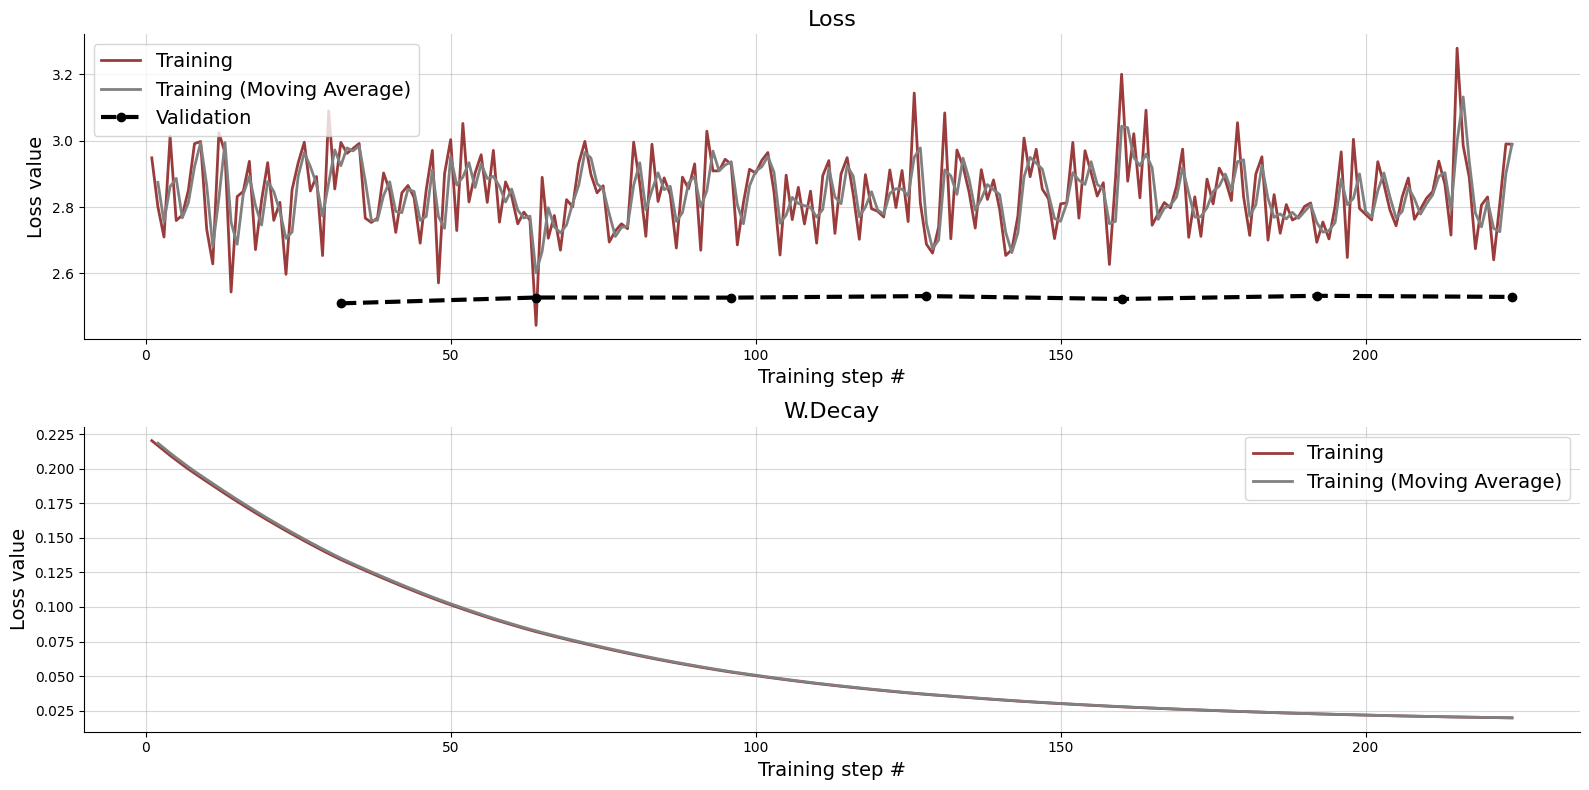

In [48]:
f = diag.plot_losses(history_2["train_losses"], history_2["val_losses"], moving_average=True)

In [49]:
# Generate some validation data
validation_sims = trainer_2.configurator(valid_data_2) 
prior_samples = validation_sims["parameters"] * prior_stds_2 + prior_means_2
# Generate posterior draws for all simulations
post_samples = amortizer_2.sample(validation_sims, n_samples=100)
post_samples = post_samples * prior_stds_2 + prior_means_2

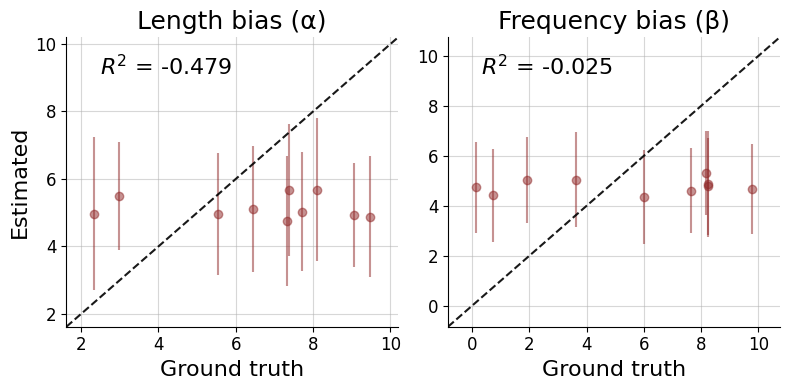

In [50]:
fig = diag.plot_recovery(post_samples[0:1000], prior_samples[0:1000], add_corr=False,
                         param_names=['Length bias (α)', 'Frequency bias (β)'],
                         )
# point_agg=np.mean, uncertainty_agg=np.std

### 4. Posterior analysis

In [51]:
a = 1
b = 10
tau = np.mean(post_samples_[:, 2])

In [52]:
fake_dist = run_model_parallel([a], [b], [tau], 1)
fake_dist = np.array(list(map(binning, fake_dist)))

In [53]:
obs_data = np.log1p(fake_dist[0])[np.newaxis, :, np.newaxis].astype(np.float32)

In [54]:
# Obtain 500 posterior draws given real data
post_samples_ = amortizer_2.sample({"summary_conditions": obs_data}, 10000)

# Undo standardization to get parameters on their original (unstandardized) scales
post_samples_ = prior_means_2 + post_samples_ * prior_stds_2

In [55]:
print(generate_latex_table(['Length bias (α)', 'Frequency bias (β)'], post_samples_))

\begin{tabular}{lrl}
\hline
 Parameter          &   Mean & HDI             \\
\hline
 Length bias (α)    &  5.045 & [-0.91  10.584] \\
 Frequency bias (β) &  4.822 & [-0.763 10.22 ] \\
\hline
\end{tabular}
